In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns


%matplotlib inline

In [2]:
def get_uniform(batch_size):
    return torch.rand(batch_size, 1)

In [3]:
def get_normal(batch_size):
    return torch.randn(batch_size, 1) + 5

In [4]:
class Generator(nn.Module):
    def __init__(self):
        """
        Generator transform the uniform distribution to the normal distibution
        """
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=1, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        
    def forward(self, x):
        return self.main(x)
    
    
class Discriminator(nn.Module):
    def __init__(self):
        """
        disc(x) return probability of x to be real class
        """
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=1, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.main(x)

gen = Generator()
disc = Discriminator()

In [5]:
generator_opt = torch.optim.SGD(gen.parameters(), lr=1e-3)
discriminator_opt = torch.optim.SGD(disc.parameters(), lr=1e-3)

In [6]:
def update_D(batch_size):
    # 1. sample real data
    # 2. compute probability of real object to be real
    
    real_samples = get_normal(batch_size)
    prob_real_is_real = disc(real_samples)
    
    
    # 1. sample noise
    # 2. obtain generated samples
    # 3. compute probability of fake object to be fake
    
    noise = get_uniform(batch_size)
    generated_samples = gen(noise)
    prob_fake_is_fake = 1 - disc(generated_samples)
    
    
    # compute loss function
    
    loss = (- torch.log(prob_real_is_real) - torch.log(prob_fake_is_fake)).mean()
    
    
    # make gradient step
    discriminator_opt.zero_grad()
    loss.backward()
    discriminator_opt.step()
    
    return loss.data.numpy().item()    

In [7]:
def update_G(batch_size):
    
    # 1. sample noise
    # 2. obtain generated samples
    # 3. compute probability of fake object to be real
    
    noise = get_uniform(batch_size)
    generated_samples = gen(noise)
    prob_fake_is_real = disc(generated_samples)
    
    
    # compute loss function
    
    loss = (- torch.log(prob_fake_is_real)).mean()
    
    
    # make gradient step
    generator_opt.zero_grad()
    loss.backward()
    generator_opt.step()
    
    return loss.data.numpy().item()    

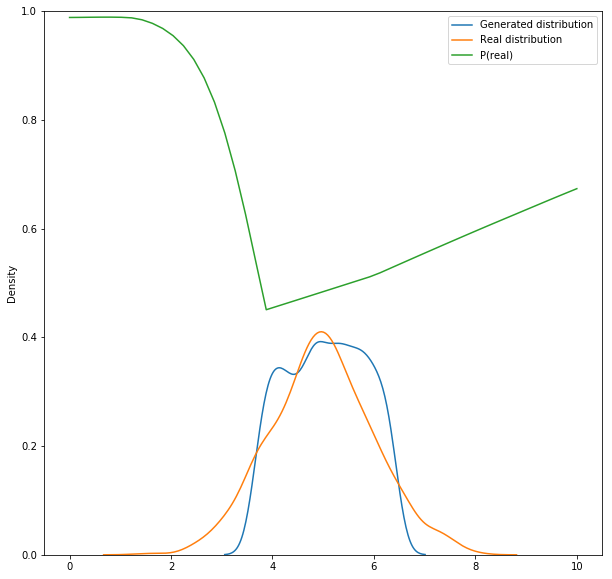

In [ ]:
N_DISC_OPERATIONS = 50 # number of updates for the discriminator on each iteration (should be tuned)
BATCH_SIZE = 64

for i in range(10000):

    for _ in range(N_DISC_OPERATIONS):
        update_D(BATCH_SIZE)
    
    update_G(BATCH_SIZE)
    
    if i % 300 == 0:
        clear_output(True)
        plt.figure(figsize=[10, 10])
        
        sns.kdeplot(gen(get_uniform(1000)).data.numpy()[:, 0], label='Generated distribution')
        sns.kdeplot(get_normal(1000).data.numpy()[:,0], label='Real distribution')
        
        x = np.linspace(0,10, dtype='float32')
        p_real = disc(torch.from_numpy(x[:, None]))
        plt.plot(x, p_real.data.numpy(), label='P(real)')
        
        axes = plt.gca()
        axes.set_ylim([0,1])
        
        plt.legend()
        plt.show()